In [210]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader, random_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import time
import torch
import torch.nn as nn
import torch.optim as optim
import torch

## Reading and Preprocessing Dataset

Dataset link: [Numenta Anomaly Benchmark (NAB)](https://www.kaggle.com/datasets/boltzmannbrain/nab)

In [211]:
# Read the dataset
dataPath = 'dataset/realAWSCloudwatch/realAWSCloudwatch/ec2_disk_write_bytes_1ef3de.csv'
data = pd.read_csv(dataPath)

In [212]:
# Get the number of entries (rows) and variables (columns)
num_entries, num_variables = data.shape

print("Number of entries (rows):", num_entries)
print("Number of variables (columns):", num_variables)

Number of entries (rows): 4730
Number of variables (columns): 2


In [213]:
# Main statistics
print(data.describe())

              value
count  4.730000e+03
mean   6.581561e+06
std    4.038568e+07
min    0.000000e+00
25%    0.000000e+00
50%    0.000000e+00
75%    0.000000e+00
max    5.474570e+08


In [214]:
# Check for missing values
print(data.isnull().sum())

timestamp    0
value        0
dtype: int64


In [215]:
data.head()

,timestamp,value
0,2014-03-01 17:34:00,0.0
1,2014-03-01 17:39:00,0.0
2,2014-03-01 17:44:00,0.0
3,2014-03-01 17:49:00,0.0
4,2014-03-01 17:54:00,0.0


## Visualizations

In [216]:
palette_color = sns.color_palette('bright') 

### Visualization: 1

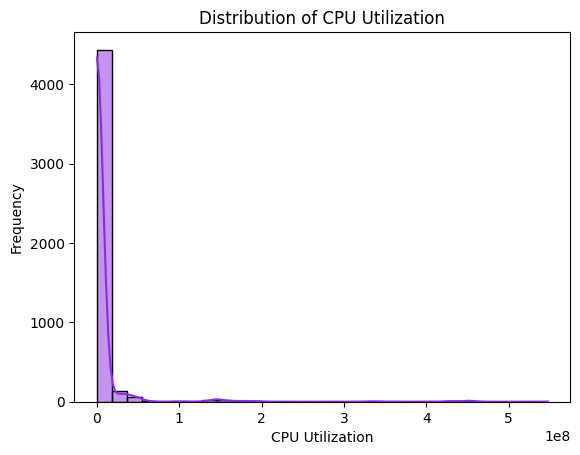

In [217]:
# Histogram of the CPU utilization values
sns.histplot(data['value'], bins=30, kde=True, color=palette_color[4])
plt.title('Distribution of CPU Utilization')
plt.xlabel('CPU Utilization')
plt.ylabel('Frequency')
plt.show()

### Visualization: 2

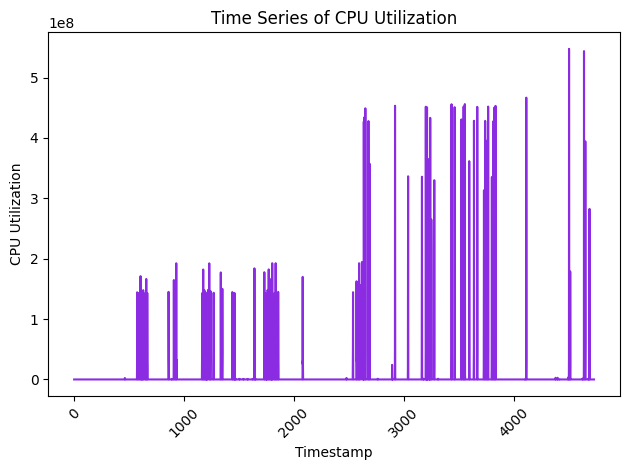

In [218]:
# Time-series plot
plt.plot(data.index, data['value'], color=palette_color[4])
plt.title('Time Series of CPU Utilization')
plt.xlabel('Timestamp')
plt.ylabel('CPU Utilization')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Visualization: 3

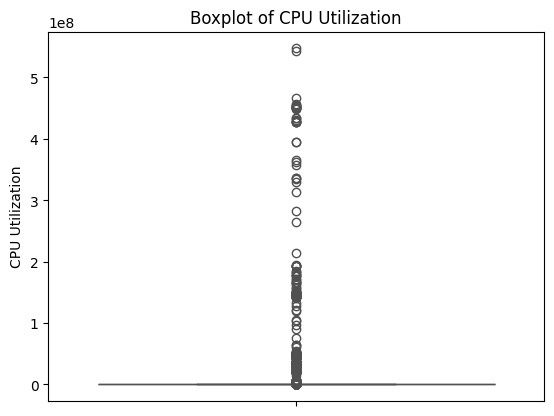

In [219]:
# Boxplot for outliers
sns.boxplot(data=data, y='value', color=palette_color[4])
plt.title('Boxplot of CPU Utilization')
plt.ylabel('CPU Utilization')
plt.show()

In [220]:
# Remove the 'timestamp' column before normalization
data_numeric = data.drop(columns=['timestamp'])

# Normalize the data
scaler = MinMaxScaler()
data_scaled = pd.DataFrame(scaler.fit_transform(data_numeric), columns=data_numeric.columns)


In [221]:
# Function to label anomalies
def label_anomaly(row):
    if row['value'] > 0.0:
        return 1
    else:
        return 0

# Applying the function to the DataFrame
data_scaled['label'] = data_scaled.apply(label_anomaly, axis=1)

## Data Splitting and Tensoring

In [222]:
# Splitting the dataset into train, validation, and test sets
train_data, test_data = train_test_split(data_scaled, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.1, random_state=42)

In [223]:
# Check the shape of the datasets
print("Training set shape:", train_data.shape)
print("Validation set shape:", val_data.shape)
print("Testing set shape:", test_data.shape)

Training set shape: (3405, 2)
Validation set shape: (379, 2)
Testing set shape: (946, 2)


In [224]:
# Converting DataFrame to PyTorch tensors
train_values = torch.tensor(train_data['value'].values, dtype=torch.float32)
train_labels = torch.tensor(train_data['label'].values, dtype=torch.float32)

val_values = torch.tensor(val_data['value'].values, dtype=torch.float32)
val_labels = torch.tensor(val_data['label'].values, dtype=torch.float32)

test_values = torch.tensor(test_data['value'].values, dtype=torch.float32)
test_labels = torch.tensor(test_data['label'].values, dtype=torch.float32)

In [225]:
# Creating PyTorch datasets
train_dataset = TensorDataset(train_values, train_labels)
val_dataset = TensorDataset(val_values, val_labels)
test_dataset = TensorDataset(test_values, test_labels)

# Creating PyTorch dataloaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [226]:
def modelTraining(model, criterion, optimizer):

    startTime = time.time()

    training_loss_plt_arr = []
    validation_loss_plt_arr = []
    testing_loss_plt_arr = []

    epochs = 50

    for epoch in range(epochs):
        # Calculate training loss
        model.train()  # Set the model to training mode
        training_loss = 0.0
        for data in train_loader:
            inputs, _ = data
            optimizer.zero_grad()
            outputs = model(inputs.unsqueeze(1))
            loss_training = criterion(outputs, inputs.unsqueeze(1))
            loss_training.backward()
            optimizer.step()

            training_loss += loss_training.item() * inputs.size(0)
        training_loss/= len(train_loader.dataset)

        # Calculate validation loss
        model.eval()  # Set the model to evaluation mode
        validation_loss = 0.0
        with torch.no_grad():
            for data in val_loader:
                inputs, _ = data
                outputs = model(inputs.unsqueeze(1))
                loss_validation = criterion(outputs, inputs.unsqueeze(1))
                validation_loss += loss_validation.item() * inputs.size(0)
            validation_loss/= len(val_loader.dataset)
        # Calculate testing loss
        testing_loss = 0.0
        with torch.no_grad():
            for data in test_loader:
                inputs, _ = data
                outputs = model(inputs.unsqueeze(1))
                loss_testing = criterion(outputs, inputs.unsqueeze(1))
                testing_loss += loss_testing.item() * inputs.size(0)
            testing_loss/= len(test_loader.dataset)

        # Print training, validation and testing loss
        if (epoch + 1) % 5 == 0:    
            print(f"Epoch [{epoch+1}/{epochs}] - Training Loss: {training_loss:.3f} - Validation Loss: {validation_loss:.3f} - Testing Loss: {testing_loss:.3f}")

        # Store losses for plotting
        training_loss_plt_arr.append(training_loss)
        validation_loss_plt_arr.append(validation_loss)
        testing_loss_plt_arr.append(testing_loss)

    print("Finished Training")

    endTime = time.time()
    time_to_train = (endTime - startTime)

    # Convert total time to minutes and seconds
    minutes = int(time_to_train // 60)
    seconds = int(time_to_train % 60)

    print(f"\nTime to train: {minutes}min {seconds}sec")

    return training_loss_plt_arr, validation_loss_plt_arr, testing_loss_plt_arr

In [227]:
# Losses visualisation
def lossesPlot(training_loss_plt_arr, validation_loss_plt_arr, testing_loss_plt_arr):
    lenLoss = len(training_loss_plt_arr) + 1
    # Plot the loss graph
    plt.plot(range(1, lenLoss), training_loss_plt_arr,
             label='Training Loss', color='red')
    plt.plot(range(1, lenLoss), validation_loss_plt_arr,
             label='Validation Loss', color='green')
    plt.plot(range(1, lenLoss), testing_loss_plt_arr,
             label='Testing Loss', color='blue')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training vs Validation vs Testing loss')
    plt.legend()
    plt.show()

In [228]:
# Updated Performance Evaluation
def loadersAccuracy(loader, model):
    model.eval()
    true_labels = []
    reconstruction_errors = []
    with torch.no_grad():
        for data in loader:
            inputs, labels = data
            outputs = model(inputs.unsqueeze(1))
            mse = nn.MSELoss(reduction='none')
            error = mse(outputs, inputs.unsqueeze(1)).mean(dim=1)
            reconstruction_errors.extend(error.numpy())
            true_labels.extend(labels.numpy())
    true_labels = np.array(true_labels)
    reconstruction_errors = np.array(reconstruction_errors)
    
    # Calculate threshold
    threshold = np.mean(reconstruction_errors) + 0.5 * np.std(reconstruction_errors)

    # Use the calculated threshold for anomaly detection
    predicted_labels = (reconstruction_errors > threshold).astype(int)
    accuracy = accuracy_score(true_labels, predicted_labels)

    return accuracy, true_labels, predicted_labels, reconstruction_errors


def perfEvaluation(model):
    model.eval()

    # Accuracies
    test_accuracy, test_trueLabels, test_predictedLabels, test_reconstruction_errors = loadersAccuracy(
        test_loader, model)
    print(f"Accuracy on the testing dataset = {test_accuracy:.2f}")

    valid_accuracy, _, _, _ = loadersAccuracy(val_loader, model)
    train_accuracy, _, _, _ = loadersAccuracy(train_loader, model)

    # Convert labels and predicted from list to tensor for metric calucaltions
    test_predictedLabels = torch.tensor(test_predictedLabels)
    test_trueLabels = torch.tensor(test_trueLabels)

    # Precision, Recall, Fscore
    precision = precision_score(test_trueLabels, test_predictedLabels)
    recall = recall_score(test_trueLabels, test_predictedLabels)
    f1score = f1_score(test_trueLabels, test_predictedLabels)
    print(f"Precision = {precision:.2f}")
    print(f"Recall = {recall:.2f}")
    print(f"Fscore = {f1score:.2f}")

    # Plotting the reconstruction errors
    plt.hist(test_reconstruction_errors, bins=50)
    plt.xlabel('Reconstruction error')
    plt.ylabel('Frequency')
    plt.title('Reconstruction error distribution on Test set')
    plt.show()

    # Plot the Accuracies
    labels = ['Training', 'Validation', 'Test']
    accuracies = [train_accuracy, valid_accuracy, test_accuracy]
    bars = plt.bar(labels, accuracies, color=['red', 'green', 'blue'])
    plt.xlabel('Splits')
    plt.ylabel('Accuracy')
    plt.title('Accuracies')

    # Adjust text position to be above each bar
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2.0, height, f'{height:.2f}', ha='center', va='bottom')

    plt.show()

    # Plot Confusion Matrix
    cm = confusion_matrix(test_trueLabels, test_predictedLabels)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Oranges")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted class")
    plt.ylabel("True class")
    plt.show()

## Model 1: Base Autoencoder

In [229]:
class BaseAutoencoder(nn.Module):
    def __init__(self):
        super(BaseAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(1, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

Model1 Architecture

BaseAutoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=1, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=16, bias=True)
    (3): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=16, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=1, bias=True)
    (3): Sigmoid()
  )
)

Epoch [5/50] - Training Loss: 0.254 - Validation Loss: 0.252 - Testing Loss: 0.251
Epoch [10/50] - Training Loss: 0.241 - Validation Loss: 0.240 - Testing Loss: 0.239
Epoch [15/50] - Training Loss: 0.227 - Validation Loss: 0.224 - Testing Loss: 0.224
Epoch [20/50] - Training Loss: 0.209 - Validation Loss: 0.207 - Testing Loss: 0.206
Epoch [25/50] - Training Loss: 0.191 - Validation Loss: 0.189 - Testing Loss: 0.189
Epoch [30/50] - Training Loss: 0.170 - Validation Loss: 0.167 - Testing Loss: 0.167
Epoch [35/50] - Training Loss: 0.146 - Validation Loss: 0.144 - Testing Loss: 0.144
Epoch [40

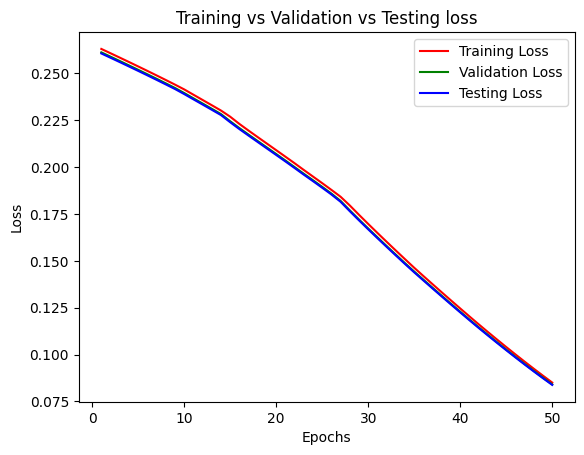

Accuracy on the testing dataset = 0.91
Precision = 1.00
Recall = 0.11
Fscore = 0.20


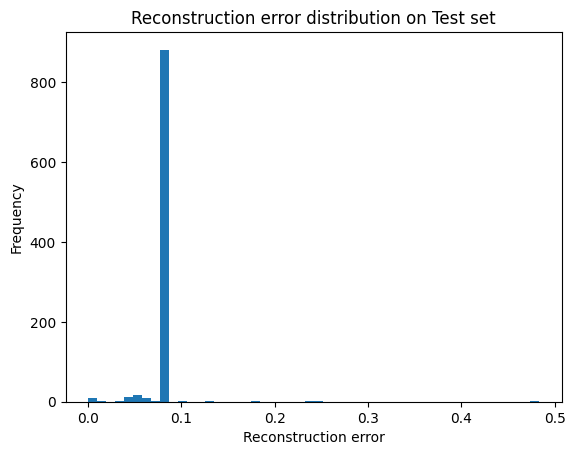

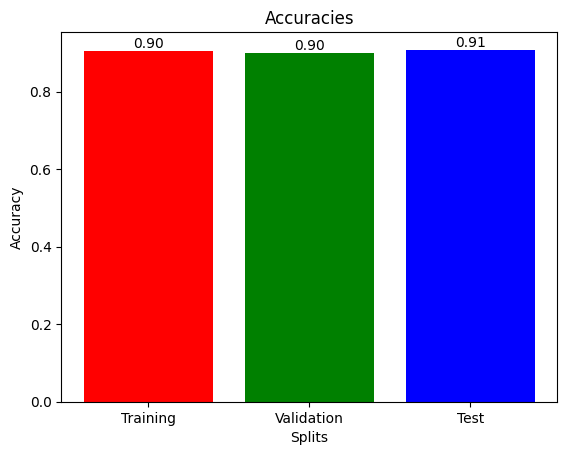

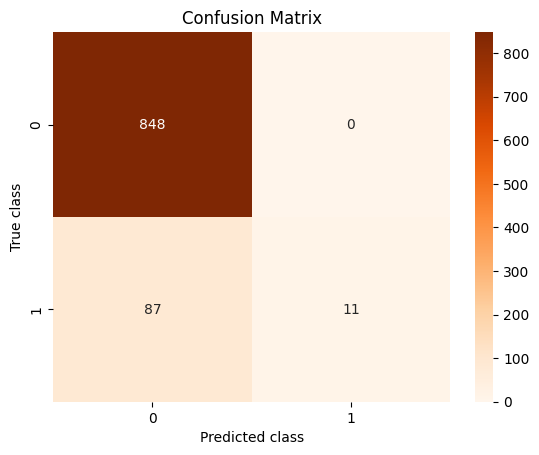

In [234]:
model1 = BaseAutoencoder()
print("Model1 Architecture\n")
print(model1)
print()
criterion = nn.MSELoss()
optimizer = optim.Adam(model1.parameters(), lr=0.00001)
training_loss_plt_arr, validation_loss_plt_arr, testing_loss_plt_arr = modelTraining(model1, criterion, optimizer)
lossesPlot(training_loss_plt_arr, validation_loss_plt_arr, testing_loss_plt_arr)
perfEvaluation(model1)

## Model 2: Base Autoencoder and Dense Layers

In [199]:
class DenseAutoencoder(nn.Module):
    def __init__(self):
        super(DenseAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(1, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

Model2 Architecture

DenseAutoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=1, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=64, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=1, bias=True)
    (5): Sigmoid()
  )
)

Epoch [5/50] - Training Loss: 0.162 - Validation Loss: 0.145 - Testing Loss: 0.145
Epoch [10/50] - Training Loss: 0.017 - Validation Loss: 0.016 - Testing Loss: 0.016
Epoch [15/50] - Training Loss: 0.006 - Validation Loss: 0.008 - Testing Loss: 0.008
Epoch [20/50] - Training Loss: 0.005 - Validation Loss: 0.007 - Testing Loss: 0.008
Epoch [25/50] - Training Loss: 0.005 - Validation Loss: 0.007 - Testing Loss: 0.007
Epoch [30/50] - 

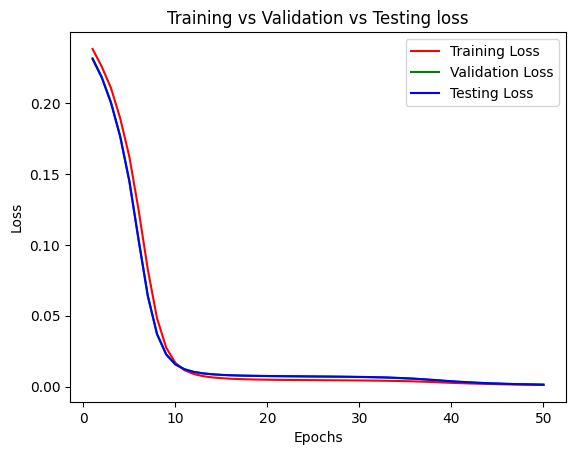

Accuracy on the testing dataset = 0.92
Precision = 1.00
Recall = 0.23
Fscore = 0.38


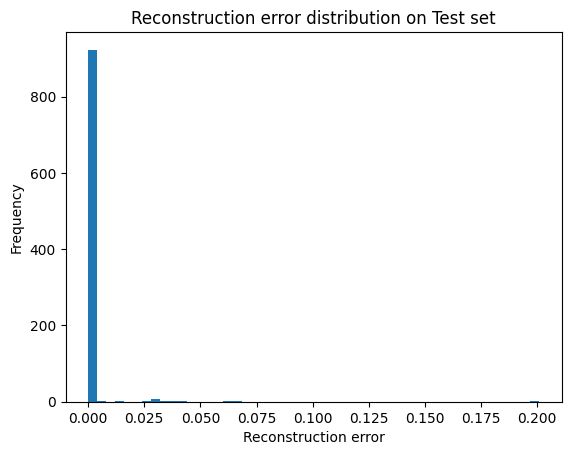

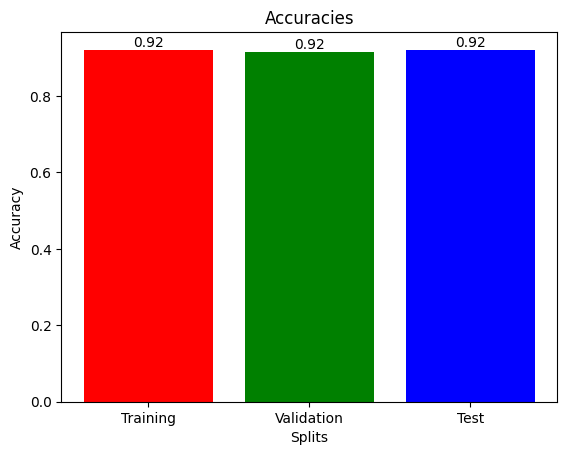

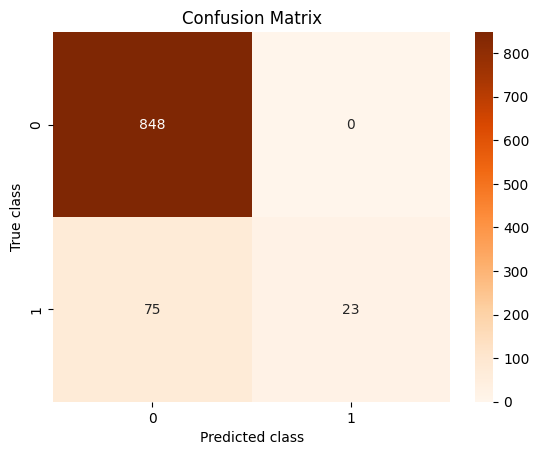

In [242]:
model2 = DenseAutoencoder()
print("Model2 Architecture\n")
print(model2)
print()
criterion = nn.MSELoss()
optimizer = optim.Adam(model2.parameters(), lr=0.00001)
training_loss_plt_arr, validation_loss_plt_arr, testing_loss_plt_arr = modelTraining(model2, criterion, optimizer)
lossesPlot(training_loss_plt_arr, validation_loss_plt_arr, testing_loss_plt_arr)
perfEvaluation(model2)

## Model 3: Base Autoencoder, Dense Layers and tanh Activation Function

In [239]:
class TanhAutoencoder(nn.Module):
    def __init__(self):
        super(TanhAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(1, 256),
            nn.Tanh(),
            nn.Linear(256, 128),
            nn.Tanh(),
            nn.Linear(128, 64),
            nn.Tanh(),
        )
        self.decoder = nn.Sequential(
            nn.Linear(64, 128),
            nn.Tanh(),
            nn.Linear(128, 256),
            nn.Tanh(),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

Model3 Architecture

TanhAutoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=1, out_features=256, bias=True)
    (1): Tanh()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): Tanh()
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): Tanh()
  )
  (decoder): Sequential(
    (0): Linear(in_features=64, out_features=128, bias=True)
    (1): Tanh()
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): Tanh()
    (4): Linear(in_features=256, out_features=1, bias=True)
    (5): Sigmoid()
  )
)

Epoch [5/50] - Training Loss: 0.015 - Validation Loss: 0.014 - Testing Loss: 0.014
Epoch [10/50] - Training Loss: 0.006 - Validation Loss: 0.008 - Testing Loss: 0.008
Epoch [15/50] - Training Loss: 0.005 - Validation Loss: 0.007 - Testing Loss: 0.008
Epoch [20/50] - Training Loss: 0.005 - Validation Loss: 0.007 - Testing Loss: 0.007
Epoch [25/50] - Training Loss: 0.005 - Validation Loss: 0.007 - Testing Loss: 0.007
Epoch [30/50] - T

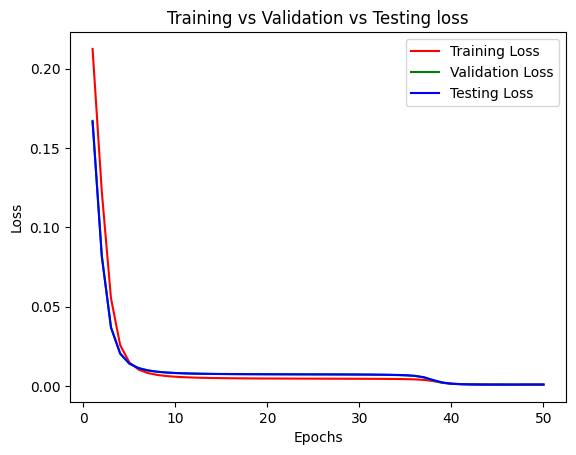

Accuracy on the testing dataset = 0.92
Precision = 1.00
Recall = 0.20
Fscore = 0.34


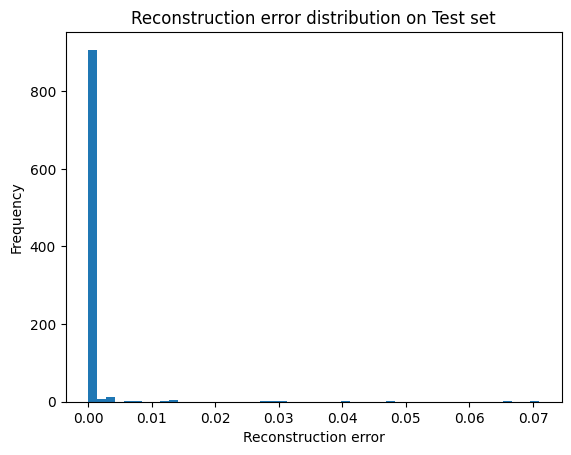

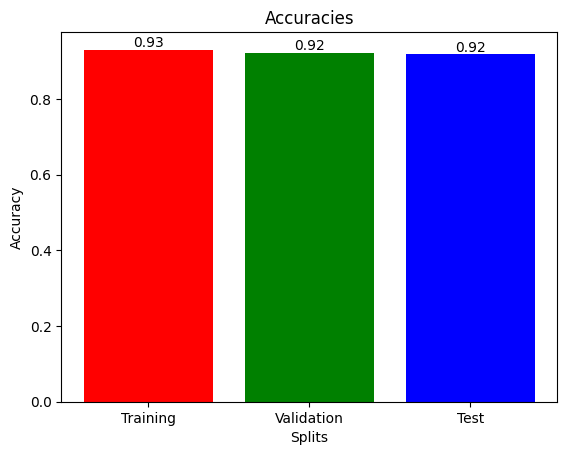

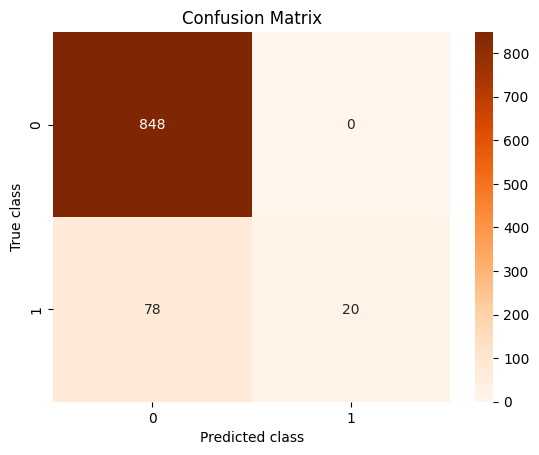

In [240]:
model3 = TanhAutoencoder()
print("Model3 Architecture\n")
print(model3)
print()
criterion = nn.MSELoss()
optimizer = optim.Adam(model3.parameters(), lr=0.00001)
training_loss_plt_arr, validation_loss_plt_arr, testing_loss_plt_arr = modelTraining(model3, criterion, optimizer)
lossesPlot(training_loss_plt_arr, validation_loss_plt_arr, testing_loss_plt_arr)
perfEvaluation(model3)

## Model 4: Base Autoencoder, Dense Layers, tanh Activation Function and Dropout

In [203]:
class DropoutAutoencoder(nn.Module):
    def __init__(self):
        super(DropoutAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(1, 256),
            nn.Tanh(),
            nn.Dropout(0.2),  # Add dropout layer
            nn.Linear(256, 128),
            nn.Tanh(),
            nn.Linear(128, 64),
            nn.Tanh(),
        )
        self.decoder = nn.Sequential(
            nn.Linear(64, 128),
            nn.Tanh(),
            nn.Linear(128, 256),
            nn.Tanh(),
            nn.Dropout(0.2),  # Add dropout layer
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

Model4 Architecture

DropoutAutoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=1, out_features=256, bias=True)
    (1): Tanh()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=256, out_features=128, bias=True)
    (4): Tanh()
    (5): Linear(in_features=128, out_features=64, bias=True)
    (6): Tanh()
  )
  (decoder): Sequential(
    (0): Linear(in_features=64, out_features=128, bias=True)
    (1): Tanh()
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): Tanh()
    (4): Dropout(p=0.2, inplace=False)
    (5): Linear(in_features=256, out_features=1, bias=True)
    (6): Sigmoid()
  )
)

Epoch [5/50] - Training Loss: 0.016 - Validation Loss: 0.014 - Testing Loss: 0.014
Epoch [10/50] - Training Loss: 0.006 - Validation Loss: 0.008 - Testing Loss: 0.008
Epoch [15/50] - Training Loss: 0.005 - Validation Loss: 0.007 - Testing Loss: 0.008
Epoch [20/50] - Training Loss: 0.005 - Validation Loss: 0.007 - Testing Loss: 0.007
Epoch [25/50] - Trai

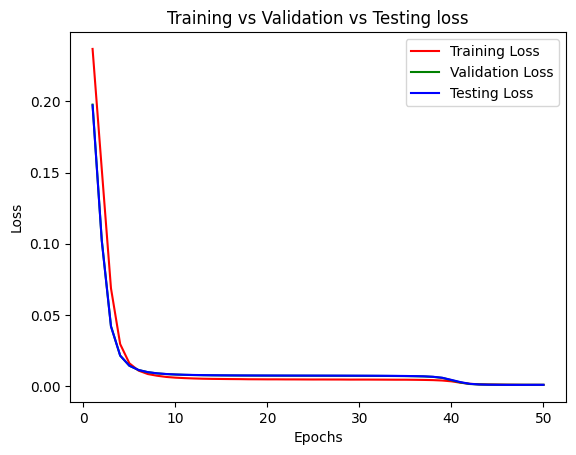

Accuracy on the testing dataset = 0.93
Precision = 1.00
Recall = 0.35
Fscore = 0.52


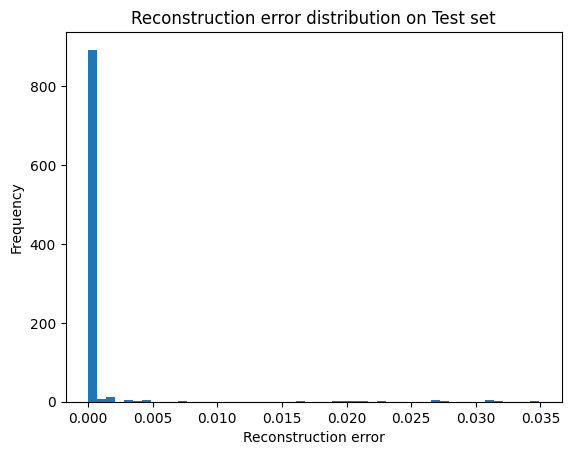

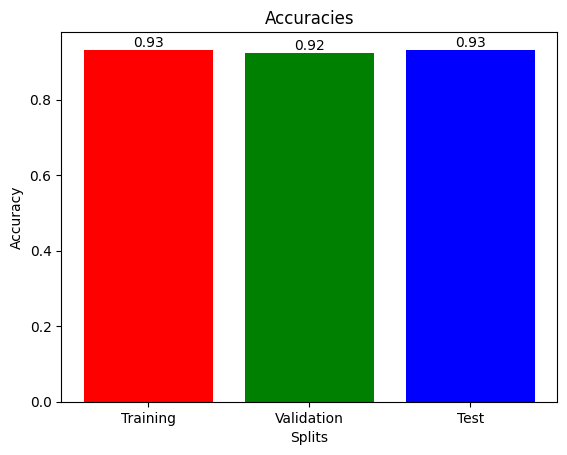

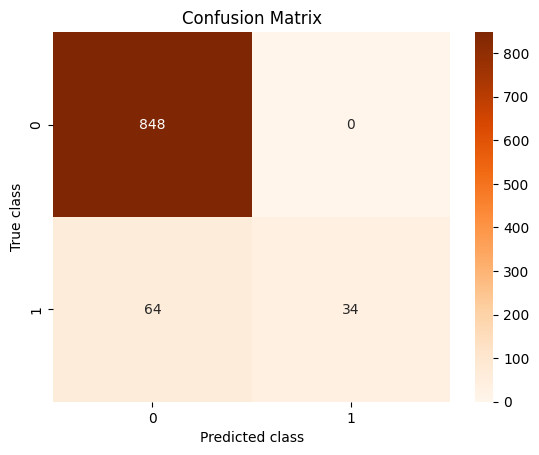

In [241]:
model4 = DropoutAutoencoder()
print("Model4 Architecture\n")
print(model4)
print()
criterion = nn.MSELoss()
optimizer = optim.Adam(model4.parameters(), lr=0.00001)
training_loss_plt_arr, validation_loss_plt_arr, testing_loss_plt_arr = modelTraining(model4, criterion, optimizer)
lossesPlot(training_loss_plt_arr, validation_loss_plt_arr, testing_loss_plt_arr)
perfEvaluation(model4)

### Best model weights
<b>Model4</b> i.e. model with Base Autoencoder, Dense Layers, tanh Activation Function and Dropout performed best among all other models.

In [243]:
# Save model weights with best metrics
torch.save(model4.state_dict(), 'ngupta22_jatinjay_assignment2_part_2.pt')

# References

1. https://pandas.pydata.org/docs/
1. https://numpy.org/doc/
1. https://matplotlib.org/stable/index.html
1. https://scikit-learn.org/stable/
1. https://seaborn.pydata.org/
1. https://pytorch.org/tutorials/
1. https://cybersecurity.springeropen.com/articles/10.1186/s42400-022-00134-9
1. https://www.kaggle.com/datasets/boltzmannbrain/nab
1. Part 3, Steps 4 and 6 is based on CSE 574 Machine Learning Assignment 2 Part 3 submission by Nikhil Gupta